We are using the dataset called "GTZAN", which is widely used in Music Genre Classification.
Our goal is to use audios' mfccs to make the classification. This data_deal.ipynb will show how mfccs are generated.

In [159]:
import numpy as np 
import pandas as pd 
import librosa
import os
import tqdm
import matplotlib.pyplot as plt
import random
import librosa.display
from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, TensorDataset
from sklearn.metrics import classification_report
from sklearn import metrics

In [160]:
def seed_torch(seed):
    random.seed(seed) # python seed
    os.environ['PYTHONHASHSEED'] = str(seed) # 设置python哈希种子，for certain hash-based operations (e.g., the item order in a set or a dict）。seed为0的时候表示不用这个feature，也可以设置为整数。 有时候需要在终端执行，到脚本实行可能就迟了。
    np.random.seed(seed) # If you or any of the libraries you are using rely on NumPy, 比如Sampling，或者一些augmentation。 哪些是例外可以看https://pytorch.org/docs/stable/notes/randomness.html
    torch.manual_seed(seed) # 为当前CPU设置随机种子。 pytorch官网倒是说(both CPU and CUDA)
    torch.cuda.manual_seed(seed) # 为当前GPU设置随机种子
    # torch.cuda.manual_seed_all(seed) # 使用多块GPU时，均设置随机种子
    torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = True # 设置为True时，cuDNN使用非确定性算法寻找最高效算法
    # torch.backends.cudnn.enabled = True # pytorch使用CUDANN加速，即使用GPU加速
    
seed_torch(seed=32)

First we should read the data.

In [161]:
def data_read(directory=r"F:\music\archive\Data\genres_original"): # change the directory if you like 
    data = [] # Store all data (read from music)
    labels = [] # Store corresponding labels
    srs = []

    x = 0

    for dirname, _, filenames in os.walk(r"F:\music\archive\Data\genres_original"):
        for filename in filenames:
            # Get name and skip the broken
            if x == 554:  # skip the broken one 
                x += 1
                continue
            filename = os.path.join(dirname, filename)
            
            y, sr = librosa.load(filename)
            # print(filename)
            label = filename.split('\\')[5]

            # Append them to the final data
            data.append(y)
            labels.append(label)
            srs.append(sr)
            x += 1
            #print(x)  # counting
    #print(len(data))
            
    return data, labels, srs

In [162]:
data, labels, srs = data_read() 

Get one random sample to show whether we read the data successfully.

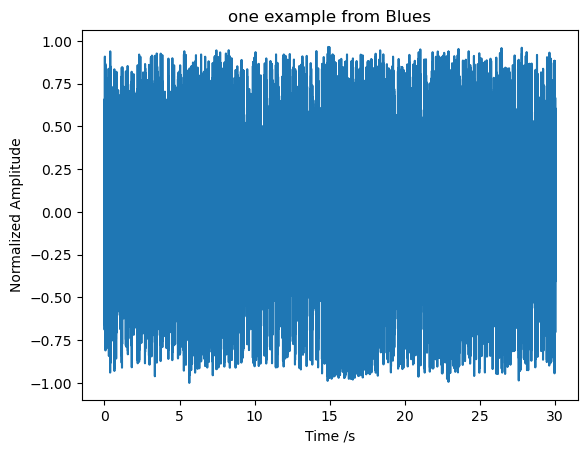

In [163]:
def check(): 
    fig, axi = plt.subplots(1,1) # initialize
    ind = random.randint(0, len(labels)-1) # randomly choose one index
    times = [sample/srs[ind] for sample in range(len(data[ind]))] # get time axis 
    axi.plot(times, data[ind])
    axi.set_ylabel('Normalized Amplitude')
    axi.set_xlabel('Time /s')
    axi.set(title = "one example from " + labels[ind].capitalize())

    plt.show()

check()

Then we need to extract mfccs features from "data"

In [164]:
def get_mfcc(data, srs, num_mfcc):
    '''
        input: data : array like data structure
               src : sampling rates
               num_mfcc: how many mfcc features you want

        return: mfccs
    '''
    mfccs = []
    for i in range(len(data)):
        mfcc = librosa.feature.mfcc(y=data[i], sr=srs[i], n_mfcc=num_mfcc).T
        mfccs.append(mfcc) # every sample we get one array of mfccs and append it.
        
    return mfccs # contains every music's mfcc

In [165]:
mfccs = get_mfcc(data, srs, num_mfcc=40)

Then we need to pad mfccs to make them have the same length

In [166]:
max_length = len(max(mfccs, key=len)) # get the max length
def pad_mfcc(mfccs, max_length):
    'pads'
    mfccs_padded = []
    for mfcc in mfccs:
        mfcc_padded = np.pad(mfcc, pad_width=[(0,max_length-mfcc[:,0].shape[0]),(0,0)])
        mfccs_padded.append(mfcc_padded)
    return mfccs_padded

In [167]:
mfccs_padded = pad_mfcc(mfccs, max_length)

Next, we put the mfccs_padded into dataloader

In [168]:
# convert data to numpy array
X = np.asarray(mfccs_padded)  
# Mapping labels 
codes = {
    'blues':0,
    'classical':1,
    'country':2,
    'disco':3,
    'hiphop':4,
    'jazz':5,
    'metal':6,
    'pop':7,
    'reggae':8,
    'rock':9
}

df_map = pd.DataFrame (labels, columns = ['labels'])
print(df_map)
df_map['labels'] = df_map['labels'].map(codes)
print(df_map)
y = df_map['labels'].to_numpy()
print(y)

    labels
0    blues
1    blues
2    blues
3    blues
4    blues
..     ...
994   rock
995   rock
996   rock
997   rock
998   rock

[999 rows x 1 columns]
     labels
0         0
1         0
2         0
3         0
4         0
..      ...
994       9
995       9
996       9
997       9
998       9

[999 rows x 1 columns]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 

In [169]:
# To split train_data, valid_data and test_data
def train_val_test_split(x, y, test_size, val_size, random_state=None, stratify=None):
    x_t, x_test, y_t, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state, stratify=stratify)
    if stratify is not None:
        stratify = y_t
    x_train, x_val, y_train, y_val = train_test_split(x_t, y_t, test_size=val_size, random_state=random_state, stratify=stratify)
    
    return x_train, y_train, x_val, y_val, x_test, y_test

def to_Dataloader(x_train, y_train, x_val, y_val, x_test, y_test, batch_size, test_batch=1,shuffle=True):
    
    train_dataset = TensorDataset(torch.Tensor(x_train),torch.Tensor(y_train).type(torch.LongTensor)) # create train_dataset
    val_dataset = TensorDataset(torch.Tensor(x_val),torch.Tensor(y_val).type(torch.LongTensor)) # create val_dataset
    test_dataset = TensorDataset(torch.Tensor(x_test),torch.Tensor(y_test).type(torch.LongTensor)) # create test_dataset

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle) # create your train_dataloader
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle) # create your val_dataloader
    test_dataloader = DataLoader(test_dataset, batch_size=test_batch, shuffle=shuffle) # create your test_dataloader
    
    return train_dataloader, val_dataloader, test_dataloader

In [170]:
x_train, y_train, x_val, y_val, x_test, y_test = train_val_test_split(X, y, test_size=0.15, val_size=0.15, random_state=42, stratify=y)

train_dataloader, val_dataloader, test_dataloader = to_Dataloader(x_train, y_train, x_val, y_val, x_test, y_test, batch_size=64, test_batch=1,shuffle=True)

print('finished')

finished


We then define a class called "early stop "
It is from : "https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py"

In [171]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

After doing all things above, it is time to build our model to train this dataset!

For the first model, we try to Reproducing GoogleNet:

In [172]:
# A class to define the Inception
class Inception(nn.Module):
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        #1X1 kernel
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        #1X1,3X3 kernel
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        #1X1,5X5 kernel
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)
        #maxpool, 1x1 kernel
    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # Sequentialize
        return torch.cat((p1, p2, p3, p4), dim=1)
    

class GoogleNet(nn.Module):
    def __init__(self):
        super(GoogleNet, self).__init__()
        self.num_conv_layers = 5
        b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

        b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

        b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

        b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

        b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())
        #seq = [b1, b2, b3, b4, b5]
        self.fitter = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

    def forward(self, x):

        x = x.transpose(1,2)
        x.unsqueeze_(1)
        out = self.fitter(x)
        return out

In [173]:
# Then we wanna define a resnet
class MusicGenreModel(nn.Module):
    def __init__(self, classes=10):
        super().__init__()

        self.classes = classes
        self.linear1 = nn.Linear(20, 200)
        self.linear2 = nn.Linear(200, 100)
        self.output = nn.Linear(100, self.classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        x = torch.relu_(x)
        x = self.linear2(x)
        x = torch.relu_(x)
        
        return F.softmax(self.output(x), dim=1)


In [174]:
# check the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Build functions which used for training and predicting

In [175]:
def training_loop(model, train_dataloader, optimizer, device=device):

    model.train() # Sets model to train mode
    batch_losses = []

    for x_batch, y_batch in train_dataloader:
        # Move batches to device
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        # Clear gradients
        optimizer.zero_grad()

        yhat = model(x_batch)  #predictions on x
        
        # Forward pass
        loss = loss_function(yhat, y_batch)
        
        # Backward and optimize
        loss.backward()

        # Update parameters
        optimizer.step()

        batch_losses.append(loss.data.item())

    train_loss = np.mean(batch_losses)

    return train_loss  # Return train_loss and anything else you need

def validation_loop(model, val_dataloader, device=device):

    model.eval() # Sets model to val mode

    batch_losses = []

    for x_batch, y_batch in val_dataloader:

        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        yhat = model(x_batch)  #predictions on x
        
        loss = loss_function(yhat, y_batch)

        batch_losses.append(loss.data.item())

    val_loss = np.mean(batch_losses)

    return val_loss

def train(model, train_dataloader, val_dataloader, optimizer, epochs, device="cuda", patience = None, temp=100):

    train_losses = []
    val_losses = []

    print(f"Initiating training.")
    
    # Check if early stop is enabled:
    if patience is not None:
        # Initialize EarlyStopping
        early_stopping = EarlyStopping(patience=patience, verbose=False, path='checkpoint.pt')

    for epoch in range(epochs):
        # Training loop

        train_loss = training_loop(model, train_dataloader, optimizer, device)
        train_losses.append(train_loss)

        # Validation loop
        with torch.no_grad():

            val_loss = validation_loop(model, val_dataloader, device)
            val_losses.append(val_loss)

        if patience != -1:
            early_stopping(val_loss, model)

            if early_stopping.early_stop:
                print("Early stop. Going back to the last checkpoint.")
                break

        if epoch % temp == 0:
            print(f"[{epoch}/{epochs}] Training loss: {train_loss:.4f}\t Validation loss: {val_loss:.4f}.")

    if patience != None and early_stopping.early_stop == True:
        print('Loading model from checkpoint...')
        model.load_state_dict(torch.load('checkpoint.pt'))
        print('Checkpoint loaded.')

    print("training finished.")
    
    # visualize the loss as the network trained
    fig = plt.figure(figsize=(10, 8))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')

    # find position of lowest validation loss
    minposs = val_losses.index(min(val_losses)) + 1
    plt.axvline(minposs, linestyle='--', color='r', label='Early Stopping Checkpoint')

    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.ylim(0, max(val_losses + train_losses))  # consistent scale
    plt.xlim(0, len(train_losses) + 1)  # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.title('Validation and Training Loss of CNN')
    plt.show()

    return model


def predict(model, test_loader, n_features, loss_function, device=device):
    # Make predictions using model
    preds = []
    true_values = []
    loss = 0
    model.eval()  # prep model for evaluation
    
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            # move to device
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Make predictions
            pred = model(x_batch)
            
            preds.append(np.argmax(pred.cpu().numpy(), axis=1)[0])
            true_values.append(y_batch.cpu().numpy()[0])
            loss += loss_function(pred, y_batch)

        #Calculate Accuracy
        accuracy = sum(np.array(preds) == np.array(true_values))/len(true_values)
        
    return preds, true_values, accuracy

Initialize the model

In [176]:
model = GoogleNet()
model.to(device)

GoogleNet(
  (fitter): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Inception(
        (p1_1): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
        (p2_1): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
        (p2_2): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (p3_1): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
        (p3_2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (p4_1): MaxPool2d(kernel_size=3, stride=1, padding=1,

In [177]:
learning_rate = 0.0001
weight_decay = 1e-4


loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = weight_decay)

Initiating training.
[0/1000] Training loss: 2.3035	 Validation loss: 2.3023.
[5/1000] Training loss: 2.1136	 Validation loss: 2.0317.
EarlyStopping counter: 1 out of 15
EarlyStopping counter: 2 out of 15
[10/1000] Training loss: 1.8832	 Validation loss: 1.9136.
EarlyStopping counter: 1 out of 15
EarlyStopping counter: 1 out of 15
[15/1000] Training loss: 1.7949	 Validation loss: 1.9552.
EarlyStopping counter: 2 out of 15
EarlyStopping counter: 3 out of 15
EarlyStopping counter: 1 out of 15
[20/1000] Training loss: 1.6279	 Validation loss: 1.8498.
EarlyStopping counter: 2 out of 15
EarlyStopping counter: 3 out of 15
EarlyStopping counter: 4 out of 15
EarlyStopping counter: 1 out of 15
[25/1000] Training loss: 1.5665	 Validation loss: 1.7585.
EarlyStopping counter: 2 out of 15
EarlyStopping counter: 1 out of 15
[30/1000] Training loss: 1.5914	 Validation loss: 1.6470.
EarlyStopping counter: 1 out of 15
EarlyStopping counter: 2 out of 15
EarlyStopping counter: 3 out of 15
[35/1000] Train

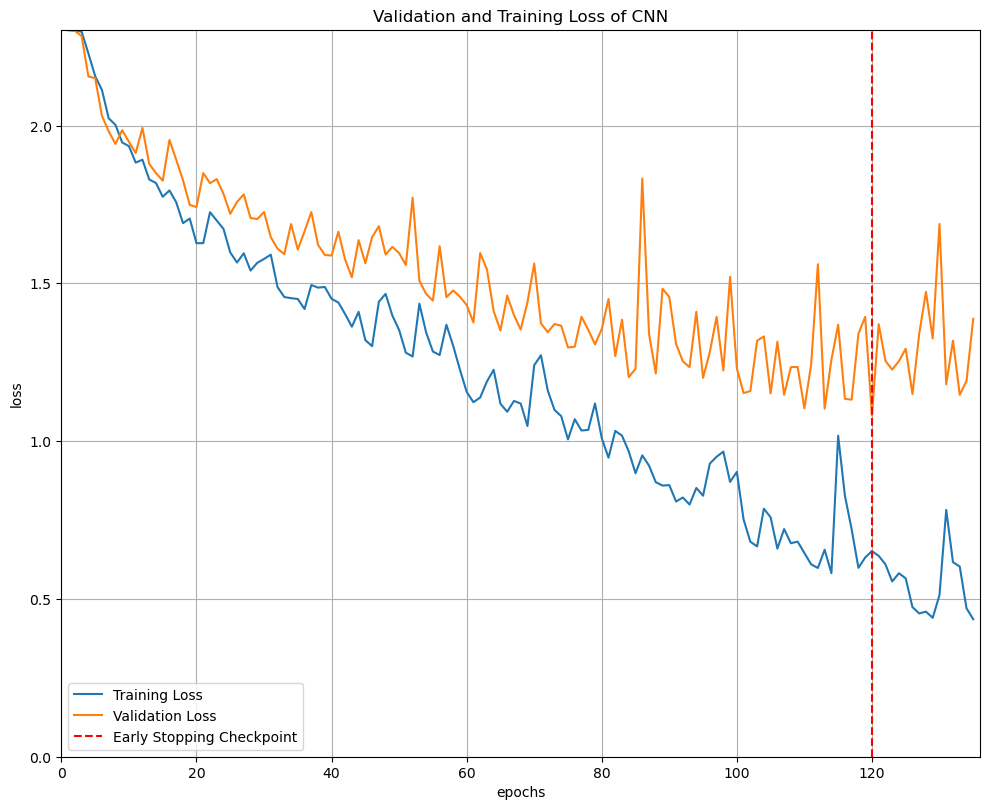

In [178]:
model = train(model, train_dataloader, val_dataloader, optimizer, epochs=1000, device="cuda", patience = 15, temp=5)

In [179]:
preds, true_values, accuracy = predict(model, test_dataloader, n_features=40, loss_function=loss_function, device=device)
print(classification_report(true_values, preds))

              precision    recall  f1-score   support

           0       0.65      0.73      0.69        15
           1       0.78      0.93      0.85        15
           2       0.56      0.60      0.58        15
           3       0.17      0.20      0.18        15
           4       0.75      0.60      0.67        15
           5       0.60      0.80      0.69        15
           6       0.86      0.80      0.83        15
           7       0.82      0.60      0.69        15
           8       0.62      0.53      0.57        15
           9       0.27      0.20      0.23        15

    accuracy                           0.60       150
   macro avg       0.61      0.60      0.60       150
weighted avg       0.61      0.60      0.60       150

